# Notebook para o PAN - Atribuição Autoral - 2018

In [1]:
%matplotlib inline
#python basic libs
from __future__ import print_function

from tempfile import mkdtemp
from shutil import rmtree
import os;
from os.path import join as pathjoin;

import re;
import glob;
import json;
import codecs;
from collections import defaultdict;
import pprint;


from pprint import pprint
from time import time
import logging


#data analysis libs
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import random;

#machine learning libs
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#preprocessing and transformation
from sklearn.preprocessing import normalize, MaxAbsScaler, MinMaxScaler;
from sklearn.preprocessing import LabelBinarizer;
from sklearn.decomposition import PCA;
from sklearn.metrics.pairwise import cosine_similarity;


from sklearn.base import BaseEstimator, ClassifierMixin

#classifiers
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import RFE,SelectFpr,SelectPercentile, chi2;

#
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#model valuation
from sklearn.model_selection import train_test_split;
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score;



In [2]:
import seaborn as sns;
from pandas.plotting import scatter_matrix

In [3]:
import platform; print(platform.platform())
print("NumPy", np.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)

Darwin-17.6.0-x86_64-i386-64bit
NumPy 1.14.2
SciPy 1.0.1
Scikit-Learn 0.19.1


### paths configuration

In [4]:
baseDir = '/Users/joseeleandrocustodio/Dropbox/mestrado/02 - Pesquisa/code';

inputDir= pathjoin(baseDir,'pan18aa');
outputDir= pathjoin(baseDir,'out',"oficial");
if not os.path.exists(outputDir):
    os.mkdir(outputDir);

## loading the dataset

In [5]:
def readCollectionsOfProblems(path):
    # Reading information about the collection
    infocollection = path+os.sep+'collection-info.json'
    with open(infocollection, 'r') as f:
        problems  = [
            {
                'problem': attrib['problem-name'],
                'language': attrib['language'],
                'encoding': attrib['encoding'],
            }
            for attrib in json.load(f)
            
        ]
    return problems;

In [6]:
problems = readCollectionsOfProblems(inputDir);

In [7]:
problems[0]

{'encoding': u'UTF-8', 'language': u'en', 'problem': u'problem00001'}

In [8]:
def readProblem(path, problem):
    # Reading information about the problem
    infoproblem = path+os.sep+problem+os.sep+'problem-info.json'
    candidates = []
    with open(infoproblem, 'r') as f:
        fj = json.load(f)
        unk_folder = fj['unknown-folder']
        for attrib in fj['candidate-authors']:
            candidates.append(attrib['author-name'])
    return unk_folder, candidates;

In [9]:
def read_files(path,label):
    # Reads all text files located in the 'path' and assigns them to 'label' class
    files = glob.glob(pathjoin(path,label,'*.txt'))
    texts=[]
    for i,v in enumerate(files):
        f=codecs.open(v,'r',encoding='utf-8')
        texts.append((f.read(),label, os.path.basename(v)))
        f.close()
    return texts

In [10]:
for index,problem in enumerate(problems):
    unk_folder, candidates_folder = readProblem(inputDir, problem['problem']); 
    problem['candidates_folder_count'] = len(candidates_folder);
    problem['candidates'] = [];
    for candidate in candidates_folder:
        problem['candidates'].extend(read_files(pathjoin(inputDir, problem['problem']),candidate));
    
    problem['unknown'] = read_files(pathjoin(inputDir, problem['problem']),unk_folder);    

In [11]:
pd.DataFrame(problems)

,candidates,candidates_folder_count,encoding,language,problem,unknown
0,"[(graceful ones.\n\n""One more,"" Marvelous said...",20,UTF-8,en,problem00001,"[(after all, his best friends. And what in the..."
1,"[(a mission.""\n\nJensen just raises an eyebrow...",5,UTF-8,en,problem00002,"[(“Potter was attractive,” Draco thought, sigh..."
2,[(qui l'avait tué mais tout était de la faute ...,20,UTF-8,fr,problem00003,[(son réveil. Sa main pulse et Draco frotte l'...
3,[(. Le canapé est vide et lorsqu'il passe deva...,5,UTF-8,fr,problem00004,"[(abasourdie.\n\nTout d'abord, elle crut que s..."
4,"[(Eppure lui la mappa l’aveva stampata, dannaz...",20,UTF-8,it,problem00005,[(– Oh. Cazzo.\nSirius era così sconvolto che ...
5,[(Yato ha trovato una lettera sul suo comodino...,5,UTF-8,it,problem00006,"[(così la tua vista, Moony?\n– Cercavo di esse..."
6,[(zmienił zdanie. Niech się stworzonko pobawi....,20,UTF-8,pl,problem00007,"[(dawniej pełna radości i ciepła, a teraz wiec..."
7,"[(Słowem, które Sherlock najczęściej słyszał w...",5,UTF-8,pl,problem00008,"[(, uderzającego o żebra niczym dzwon- niemal ..."
8,[(pero no lo ama como ama a Guignol –explicó e...,20,UTF-8,sp,problem00009,[(–La nariz puntiaguda del elfo casi rozaba el...
9,"[(incapaz de señalar un momento exacto, un pun...",5,UTF-8,sp,problem00010,[(tan parecidas hizo que su trasero latiese de...


In [12]:
#*******************************************************************************************************
import warnings
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder


def eval_measures(gt, pred):
    """Compute macro-averaged F1-scores, macro-averaged precision, 
    macro-averaged recall, and micro-averaged accuracy according the ad hoc
    rules discussed at the top of this file.
    Parameters
    ----------
    gt : dict
        Ground truth, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    pred : dict
        Predicted attribution, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    Returns
    -------
    f1 : float
        Macro-averaged F1-score
    precision : float
        Macro-averaged precision
    recall : float
        Macro-averaged recall
    accuracy : float
        Micro-averaged F1-score
    """

    actual_authors = list(gt.values())
    encoder = LabelEncoder().fit(['<UNK>'] + actual_authors)

    text_ids, gold_authors, silver_authors = [], [], []
    for text_id in sorted(gt):
        text_ids.append(text_id)
        gold_authors.append(gt[text_id])
        try:
            silver_authors.append(pred[text_id])
        except KeyError:
            # missing attributions get <UNK>:
            silver_authors.append('<UNK>')

    assert len(text_ids) == len(gold_authors)
    assert len(text_ids) == len(silver_authors)

    # replace non-existent silver authors with '<UNK>':
    silver_authors = [a if a in encoder.classes_ else '<UNK>' 
                      for a in silver_authors]

    gold_author_ints   = encoder.transform(gold_authors)
    silver_author_ints = encoder.transform(silver_authors)

    # get F1 for individual classes (and suppress warnings):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        f1 = f1_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        precision = precision_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        recall = recall_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        accuracy = accuracy_score(gold_author_ints,
                  silver_author_ints)

    return f1,precision,recall,accuracy


In [13]:
def evaluate(ground_truth_file,predictions_file):
    # Calculates evaluation measures for a single attribution problem
    gt = {}
    with open(ground_truth_file, 'r') as f:
        for attrib in json.load(f)['ground_truth']:
            gt[attrib['unknown-text']] = attrib['true-author']

    pred = {}
    with open(predictions_file, 'r') as f:
        for attrib in json.load(f):
            if attrib['unknown-text'] not in pred:
                pred[attrib['unknown-text']] = attrib['predicted-author']
    f1,precision,recall,accuracy =  eval_measures(gt,pred)
    return f1, precision, recall, accuracy

In [14]:
from sklearn.base import BaseEstimator
from scipy.sparse import issparse


class DenseTransformer(BaseEstimator):
    """Convert a sparse array into a dense array."""

    def __init__(self, return_copy=True):
        self.return_copy = return_copy
        self.is_fitted = False

    def transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        if issparse(X):
            return X.toarray()
        elif self.return_copy:
            return X.copy()
        else:
            return X

    def fit(self, X, y=None):
        """ Mock method. Does nothing.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        self
        """
        self.is_fitted = True
        return self

    def fit_transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        return self.transform(X=X, y=y)

In [15]:
from sklearn.base import BaseEstimator
from scipy.sparse import issparse


class ObfuscationTransformer(BaseEstimator):
    def __init__(self,re_from=r'(\b)(\w{0,2})\w+(\w{1,3})(\b)', re_to=r'\1\2XX\3\4', return_copy=True):
        self.re_from = re_from
        self.re_to = re_to

    def transform(self, X, y=None):
        X = np.array(X).copy();
        for i in range(len(X)):
            X[i] = re.sub(self.re_from,self.re_to, X[i])
        
        return X;

    def fit(self, X, y=None):
        return self

    def fit_transform(self, X, y=None):
        return self.transform(X=X, y=y)

### examinando o parametro min_df isoladamente

In [16]:
def runML(problem):
    print ("\nProblem: %s,  language: %s, " %(problem['problem'],problem['language']))
    
    train_docs, train_labels, _   = zip(*problem['candidates'])
    problem['training_docs_size'] = len(train_docs);
    test_docs, _, test_filename   = zip(*problem['unknown'])
    
    pipeline = Pipeline([
        ('obs',ObfuscationTransformer(re_from=r'\w',re_to='x')),
        ('vect',   TfidfVectorizer(analyzer='char',
                                   min_df=0.01,
                                   max_df=1.0,
                                   norm='l1',
                                   ngram_range=(3,5),
                                   sublinear_tf=True,
                                   smooth_idf=True,
                                   lowercase =False)),
        ('dense',  DenseTransformer()),
        ('scaler', MaxAbsScaler()),
        ('transf', PCA(0.999)),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ])
    
    
    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__min_df':(2,0.01,0.05,0.1)
    }
    
    grid_search = GridSearchCV(pipeline,
                               parameters,
                               cv=5,
                               n_jobs=-1,
                               verbose=False,
                               scoring='f1_macro')
    
    print("Performing grid search...")
    t0 = time()
    grid_search.fit(train_docs, train_labels)
    print("done in %0.3fs" % (time() - t0))

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    train_pred=grid_search.predict(train_docs);
    test_pred=grid_search.predict(test_docs);
    
    
    # Writing output file
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append({'unknown-text': test_filename[i],'predicted-author': v})
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)
    
    
    #evaluation train
    f1,precision,recall,accuracy=evaluate(
                pathjoin(inputDir, problem['problem'], 'ground-truth.json'),
                answerFile)
    
    return {
                'problem-name'  :       problem['problem'],
                "language"      :       problem['language'],
                'AuthorCount'   :       len(set(train_labels)),
                "train_doc_size":       len(train_docs),
                "train_caract_per_doc": sum([len(l) for l in train_docs])/len(train_docs),
                "test_doc_size" :       len(test_docs),
                "test_caract_per_doc":  sum([len(l) for l in test_docs])/len(test_docs),
                
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3),
                
        }, grid_search.cv_results_, best_parameters;

In [17]:
result = [];
cv_result = [];
best_parameters = [];
for problem in problems:
    r, c, b = runML(problem);
    result.append(r);
    cv_result.append(c);
    b['problem'] = problem['problem'];
    best_parameters.append(b);


Problem: problem00001,  language: en, 
Performing grid search...


/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

done in 27.827s
Best score: 0.612
Best parameters set:
	vect__min_df: 0.01

Problem: problem00002,  language: en, 
Performing grid search...
done in 8.602s
Best score: 0.871
Best parameters set:
	vect__min_df: 2

Problem: problem00003,  language: fr, 
Performing grid search...
done in 38.136s
Best score: 0.651
Best parameters set:
	vect__min_df: 2

Problem: problem00004,  language: fr, 
Performing grid search...
done in 9.879s
Best score: 0.570
Best parameters set:
	vect__min_df: 0.01

Problem: problem00005,  language: it, 
Performing grid search...
done in 36.652s
Best score: 0.651
Best parameters set:
	vect__min_df: 2

Problem: problem00006,  language: it, 
Performing grid search...
done in 9.334s
Best score: 0.796
Best parameters set:
	vect__min_df: 0.1

Problem: problem00007,  language: pl, 
Performing grid search...
done in 42.738s
Best score: 0.756
Best parameters set:
	vect__min_df: 0.05

Problem: problem00008,  language: pl, 
Performing grid search...
done in 10.630s
Best score

In [21]:
pd.DataFrame(best_parameters)[['problem','vect__min_df']]

,problem,vect__min_df
0,problem00001,0.01
1,problem00002,2.00
2,problem00003,2.00
3,problem00004,0.01
4,problem00005,2.00
5,problem00006,0.10
6,problem00007,0.05
7,problem00008,2.00
8,problem00009,0.01
9,problem00010,0.01


### analisando os demais parametros

In [18]:
def runML(problem):
    print ("\nProblem: %s,  language: %s, " %(problem['problem'],problem['language']))
    
    train_docs, train_labels, _   = zip(*problem['candidates'])
    problem['training_docs_size'] = len(train_docs);
    test_docs, _, test_filename   = zip(*problem['unknown'])
    
    pipeline = Pipeline([
        ('obs',ObfuscationTransformer(re_from=r'\w',re_to='x')),
        ('vect',   TfidfVectorizer(analyzer='char',
                                   min_df=0.01,
                                   max_df=1.0,
                                   norm='l1',
                                   lowercase =False,
                                   sublinear_tf=True)),
        ('dense',  DenseTransformer()),
        ('scaler', MaxAbsScaler()),
        ('transf', PCA()),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ])
    
    
    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__ngram_range':((2,3),(2,4),(2,5),(3,5)),
        'vect__sublinear_tf':(True, False),
        'vect__norm':('l1','l2'),
        'transf__n_components': (0.1,0.25,0.5,0.75,0.9,0.999),
    }
    
    grid_search = GridSearchCV(pipeline,
                               parameters,
                               cv=5,
                               n_jobs=-1,
                               verbose=False,
                               scoring='f1_macro')
    
    print("Performing grid search...")
    t0 = time()
    grid_search.fit(train_docs, train_labels)
    print("done in %0.3fs" % (time() - t0))

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    train_pred=grid_search.predict(train_docs);
    test_pred=grid_search.predict(test_docs);
    
    
    # Writing output file
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append({'unknown-text': test_filename[i],'predicted-author': v})
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)
    
    
    #evaluation train
    f1,precision,recall,accuracy=evaluate(
                pathjoin(inputDir, problem['problem'], 'ground-truth.json'),
                answerFile)
    
    return {
                'problem-name'  :       problem['problem'],
                "language"      :       problem['language'],
                'AuthorCount'   :       len(set(train_labels)),
                "train_doc_size":       len(train_docs),
                "train_caract_per_doc": sum([len(l) for l in train_docs])/len(train_docs),
                "test_doc_size" :       len(test_docs),
                "test_caract_per_doc":  sum([len(l) for l in test_docs])/len(test_docs),
                
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3),
                
        }, grid_search.cv_results_,best_parameters;

In [19]:
result = [];
cv_result = [];
best_parameters = [];
for problem in problems:
    r, c, b = runML(problem);
    result.append(r);
    cv_result.append(c);
    b['problem'] = problem['problem'];
    best_parameters.append(b);


Problem: problem00001,  language: en, 
Performing grid search...


/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

done in 569.713s
Best score: 0.655
Best parameters set:
	transf__n_components: 0.999
	vect__ngram_range: (2, 4)
	vect__norm: 'l2'
	vect__sublinear_tf: True

Problem: problem00002,  language: en, 
Performing grid search...
done in 147.120s
Best score: 0.970
Best parameters set:
	transf__n_components: 0.999
	vect__ngram_range: (2, 3)
	vect__norm: 'l2'
	vect__sublinear_tf: True

Problem: problem00003,  language: fr, 
Performing grid search...
done in 618.427s
Best score: 0.661
Best parameters set:
	transf__n_components: 0.999
	vect__ngram_range: (2, 4)
	vect__norm: 'l1'
	vect__sublinear_tf: True

Problem: problem00004,  language: fr, 
Performing grid search...
done in 169.592s
Best score: 0.636
Best parameters set:
	transf__n_components: 0.999
	vect__ngram_range: (3, 5)
	vect__norm: 'l1'
	vect__sublinear_tf: False

Problem: problem00005,  language: it, 
Performing grid search...
done in 702.613s
Best score: 0.658
Best parameters set:
	transf__n_components: 0.999
	vect__ngram_range: (2, 4)

In [37]:
df=pd.DataFrame(result)[['problem-name',
                     "language",
                     'AuthorCount',
                     "train_doc_size","train_caract_per_doc",
                     "test_doc_size", "test_caract_per_doc",
                     'macro-f1','macro-precision','macro-recall' ,'micro-accuracy']]

In [38]:
df

,problem-name,language,AuthorCount,train_doc_size,train_caract_per_doc,test_doc_size,test_caract_per_doc,macro-f1,macro-precision,macro-recall,micro-accuracy
0,problem00001,en,20,140,4327,105,4370,0.437,0.410,0.620,0.562
1,problem00002,en,5,35,4342,21,4296,0.264,0.300,0.397,0.238
2,problem00003,fr,20,140,4492,49,4508,0.615,0.629,0.659,0.633
3,problem00004,fr,5,35,4522,21,4532,0.559,0.650,0.707,0.524
4,problem00005,it,20,140,4720,80,4787,0.438,0.402,0.589,0.625
5,problem00006,it,5,35,4847,46,4765,0.575,0.608,0.687,0.804
6,problem00007,pl,20,140,5145,103,5200,0.468,0.485,0.527,0.456
7,problem00008,pl,5,35,5049,15,5214,0.523,0.533,0.689,0.600
8,problem00009,sp,20,140,4794,117,4788,0.564,0.569,0.638,0.598
9,problem00010,sp,5,35,4955,64,4827,0.597,0.611,0.632,0.625


In [39]:
print(df[["macro-f1"]].reset_index().to_latex(index=False).replace("     "," "))

\begin{tabular}{rr}
\toprule
 index &  macro-f1 \\
\midrule
 0 & 0.437 \\
 1 & 0.264 \\
 2 & 0.615 \\
 3 & 0.559 \\
 4 & 0.438 \\
 5 & 0.575 \\
 6 & 0.468 \\
 7 & 0.523 \\
 8 & 0.564 \\
 9 & 0.597 \\
\bottomrule
\end{tabular}



In [40]:
languages={
    'en':'inglesa',
    'sp':'espanhola',
    'it':'italiana',
    'pl':'polonesa',
    'fr':'francesa'
}

In [41]:
cv_result2 = [];
dfCV = pd.DataFrame();
for i, c in enumerate(cv_result):
    temp = pd.DataFrame(c);
    temp['problem'] = i+1;
    temp['language'] = languages[problems[i]['language']]
    dfCV = dfCV.append(temp);

for p in ['param_transf__n_components',
    'mean_test_score','std_test_score','mean_train_score',   
    'split0_test_score','split0_train_score',
    'split1_test_score','split1_train_score',
    'split2_test_score','split2_train_score',
    'split3_test_score','split3_train_score',
    'split4_test_score','split4_train_score']:
    dfCV[p]=dfCV[p].astype(np.float32);

    
dfCV =dfCV[[
    'problem',
    'language',
    'rank_test_score',
    'param_transf__n_components',
    'param_vect__ngram_range',
    'param_vect__sublinear_tf',
    'param_vect__norm',
    'mean_test_score',   
    'std_test_score',
    'mean_train_score',   

    'split0_test_score','split0_train_score',
    'split1_test_score','split1_train_score',
    'split2_test_score','split2_train_score',
    'split3_test_score','split3_train_score',
    'split4_test_score','split4_train_score',

    'mean_score_time',
    'mean_fit_time',
    'std_fit_time',
    'std_score_time',
    'std_train_score',
]];

dfCV.rename(columns={
    'param_transf__n_components':'PCA_componentes',
    'param_vect__ngram_range':'ngram_range',
    'param_vect__sublinear_tf':'sublinear_tf',
    'param_vect__smooth_idf':'smooth_idf',
    'param_vect__norm':'norm'
},inplace=True);

#print('\',\n\''.join(dfCV.columns))

In [42]:
dfCV.to_csv('PANAA2018_MASK.csv', index=False)

In [19]:
dfCV = pd.read_csv('PANAA2018_MASK.csv')

In [20]:
(dfCV[dfCV.rank_test_score == 1])[
    ['problem',
     'language',
    'rank_test_score',
    'mean_test_score',
    'std_test_score',
    'ngram_range',
    'sublinear_tf',
    'PCA_componentes']
].sort_values(by=[
    'problem',
    'mean_test_score',
    'ngram_range',
    'sublinear_tf',
    'PCA_componentes'
], ascending=[True, False,False,False,False])

,problem,language,rank_test_score,mean_test_score,std_test_score,ngram_range,sublinear_tf,PCA_componentes
86,1,inglesa,1,0.654592,0.125945,"(2, 4)",True,0.999
178,2,inglesa,1,0.969524,0.048187,"(2, 3)",True,0.999
276,3,francesa,1,0.660952,0.102029,"(2, 4)",True,0.999
381,4,francesa,1,0.636190,0.193312,"(3, 5)",False,0.999
470,5,italiana,1,0.658129,0.084886,"(2, 4)",True,0.999
549,6,italiana,1,0.834286,0.142514,"(2, 4)",False,0.900
652,7,polonesa,1,0.753810,0.084556,"(3, 5)",True,0.900
764,8,polonesa,1,0.931429,0.093314,"(3, 5)",True,0.999
766,8,polonesa,1,0.931429,0.093314,"(3, 5)",True,0.999
748,8,polonesa,1,0.931429,0.093314,"(3, 5)",True,0.900


In [21]:
dfCV.pivot_table(
            index=['problem','language','PCA_componentes'],
            columns=['norm','sublinear_tf', 'ngram_range'],
            values='mean_test_score'
        )

norm                                     l1                                \
sublinear_tf                          False                                 
ngram_range                          (2, 3)    (2, 4)    (2, 5)    (3, 5)   
problem language  PCA_componentes                                           
1       inglesa   0.100            0.093856  0.092630  0.088209  0.089399   
                  0.250            0.193707  0.257766  0.257404  0.257245   
                  0.500            0.391497  0.360374  0.431156  0.412041   
                  0.750            0.523810  0.501735  0.513912  0.511905   
                  0.900            0.525986  0.559558  0.565952  0.552857   
                  0.999            0.517370  0.547778  0.542347  0.553946   
2       inglesa   0.100            0.370884  0.332789  0.265986  0.294558   
                  0.250            0.585034  0.521905  0.622857  0.622857   
                  0.500            0.672381  0.672381  0.665714  0.665714   
                  0.750            0.740952  0.720000  0.652381  0.698095   
                  0.900            0.740952  0.788571  0.684762  0.618095   
                  0.999            0.800272  0.805714  0.767619  0.817143   
3       francesa  0.100            0.142439  0.146792  0.194388  0.204592   
                  0.250            0.345986  0.348605  0.394592  0.376803   
                  0.500            0.435000  0.448571  0.506463  0.516599   
                  0.750            0.486156  0.524195  0.523254  0.518730   
                  0.900            0.516667  0.547687  0.501667  0.537211   
                  0.999            0.524660  0.574524  0.570476  0.570476   
4       francesa  0.100            0.268571  0.206667  0.225397  0.281587   
                  0.250            0.214422  0.214422  0.269524  0.267755   
                  0.500            0.349524  0.418730  0.340000  0.296825   
                  0.750            0.444444  0.421905  0.365714  0.448254   
                  0.900            0.548571  0.543810  0.569524  0.569524   
                  0.999            0.477143  0.602993  0.598095  0.636190   
5       italiana  0.100            0.180782  0.243673  0.243163  0.235986   
                  0.250            0.357687  0.378605  0.375986  0.395136   
                  0.500            0.520669  0.562449  0.546939  0.529104   
                  0.750            0.581054  0.557007  0.570408  0.583027   
                  0.900            0.580510  0.574184  0.575170  0.568027   
                  0.999            0.572313  0.579456  0.571599  0.566327   
6       italiana  0.100            0.508571  0.520000  0.634286  0.600272   
                  0.250            0.737143  0.737143  0.760000  0.710476   
                  0.500            0.796191  0.796191  0.796191  0.746667   
                  0.750            0.739048  0.805714  0.805714  0.786667   
                  0.900            0.796191  0.834286  0.805714  0.805714   
                  0.999            0.765714  0.796191  0.796191  0.796191   
7       polonesa  0.100            0.291531  0.363435  0.325238  0.378322   
                  0.250            0.548605  0.562143  0.526497  0.545590   
                  0.500            0.516190  0.597857  0.606531  0.593912   
                  0.750            0.589671  0.605556  0.645238  0.619558   
                  0.900            0.578413  0.616905  0.659048  0.671191   
                  0.999            0.616190  0.641905  0.687143  0.680476   
8       polonesa  0.100            0.615238  0.513605  0.449116  0.449116   
                  0.250            0.583809  0.583809  0.604082  0.608844   
                  0.500            0.748571  0.834286  0.813333  0.786667   
                  0.750            0.900952  0.931429  0.893333  0.893333   
                  0.900            0.866667  0.904762  0.874286  0.874286   
                  0.999            0.904762  0.931429  0.931429  0.931429

In [22]:
pd.options.display.precision = 3  
print(u"\\begin{table}[h]\n\\centering\n\\caption{Medida F1 para os parâmetros }")

print(dfCV[dfCV.PCA_componentes == 0.999].pivot_table(
        index=['problem','language','sublinear_tf','norm'],
        columns=['ngram_range'],
        values='mean_test_score'
    ).to_latex().replace("     "," "))
print ("\label{tab:modeloPalavra}")
print(r"\end{table}")

\begin{table}[h]
\centering
\caption{Medida F1 para os parâmetros }


IndexError: list index out of range

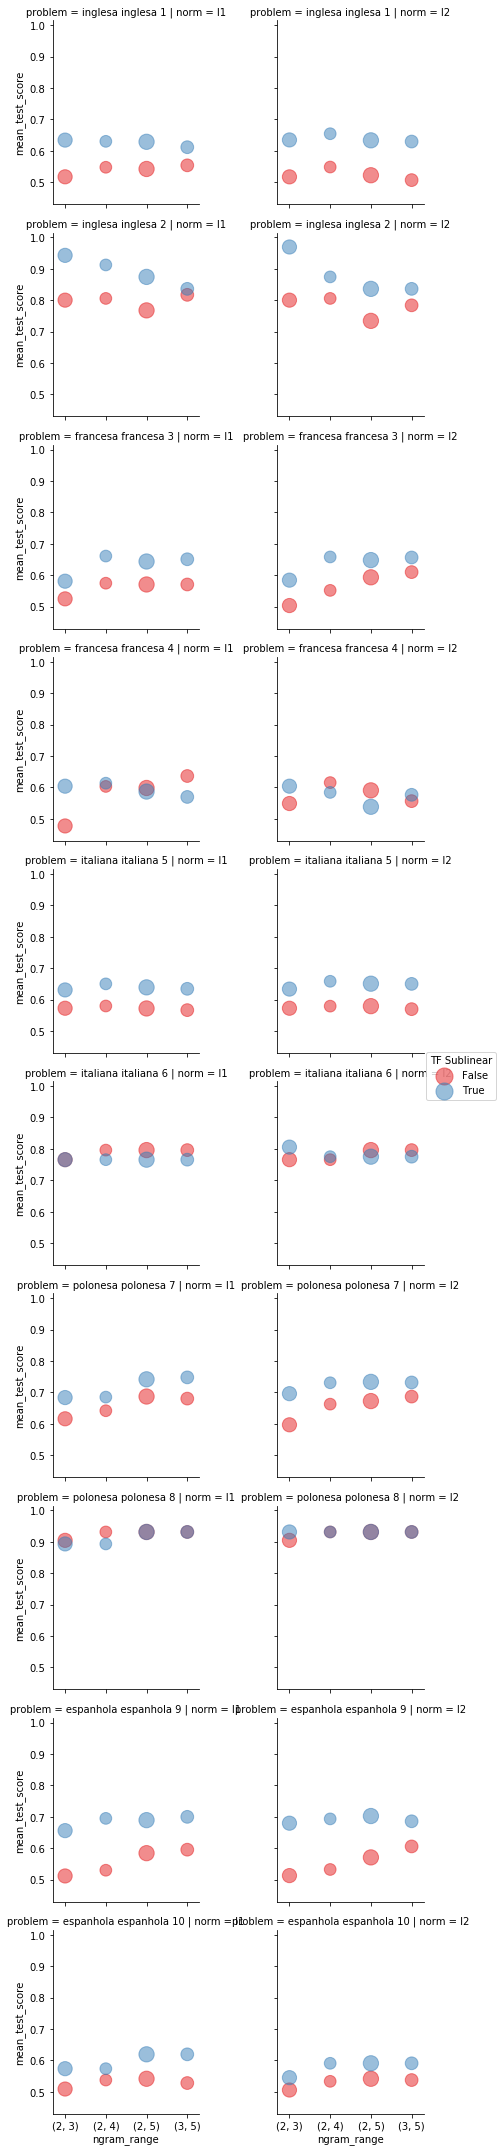

In [23]:
d = dfCV[dfCV.PCA_componentes > 0.9].rename(columns={'language':u'Língua', 'sublinear_tf':'TF Sublinear'})
d = d [ d.norm.isna() == False]
d['autorNumber'] = d.problem.map(lambda x: 20 if x % 2==0  else 5)
d.problem = d.apply(lambda x: x[u'Língua'] +" "+ str(x[u'problem']), axis=1)
d.std_test_score =d.std_test_score / d.std_test_score.quantile(0.95) *500;
d.std_test_score +=1;
d.std_test_score = d.std_test_score.astype(np.int64);
d.problem = d.apply(lambda x: x[u'Língua'] +" "+ str(x[u'problem']), axis=1)
g = sns.FacetGrid(d, row='problem', hue='TF Sublinear',  col="norm", size=3,palette="Set1")
g.map(plt.scatter, "ngram_range", "mean_test_score", alpha=0.5, s=d.std_test_score.values).add_legend();

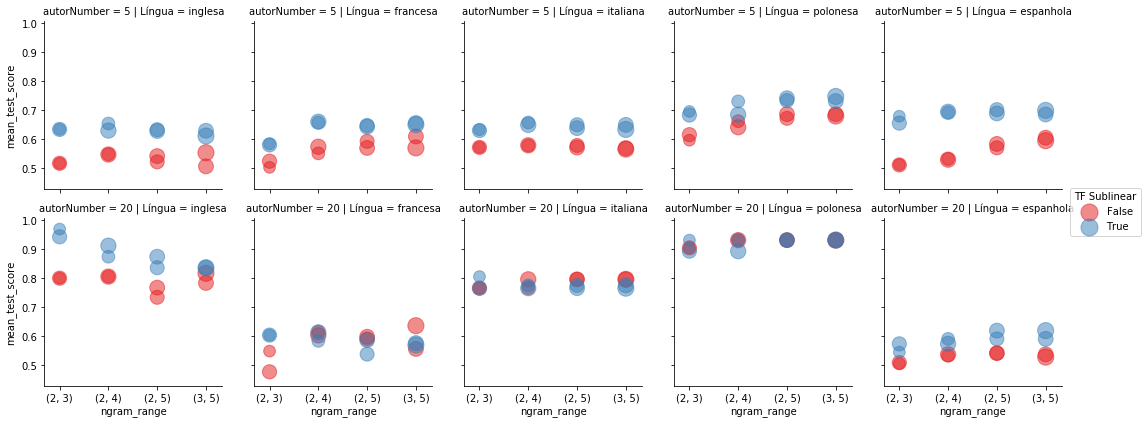

In [24]:
g = sns.FacetGrid(d, row='autorNumber', hue='TF Sublinear',  col=u"Língua", size=3,palette="Set1")
g.map(plt.scatter, "ngram_range", "mean_test_score", alpha=0.5, s=d.std_test_score.values).add_legend();

/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


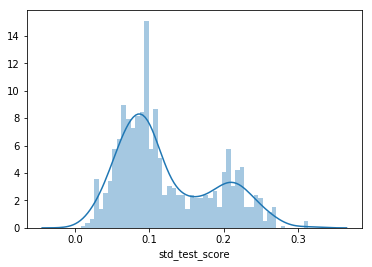

In [25]:
sns.distplot(dfCV.std_test_score, bins=50);

In [26]:
import statsmodels.api as sm

/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [27]:
d = dfCV[['mean_test_score','problem', 'language','sublinear_tf','norm','ngram_range','PCA_componentes']].copy();
d.sublinear_tf=d.sublinear_tf.apply(lambda x: 1 if x else 0)
d['autorNumber'] = d.problem.map(lambda x: 20 if x % 2==0  else 5)
d.norm.fillna(value='None', inplace=True);
d.PCA_componentes = np.log(d.PCA_componentes);

_, d['ngram_max'] = zip(*d.ngram_range.str.replace(r'[^\d,]','').str.split(',').values.tolist())
#d.ngram_min = d.ngram_min.astype(np.uint8);
d.ngram_max = d.ngram_max.astype(np.uint8);
d.drop(columns=['ngram_range','problem'], inplace=True)
#d['intercept'] = 1;

d=pd.get_dummies(d, columns=['language', 'norm', 'ngram_max'])

In [28]:
d.describe()

,mean_test_score,sublinear_tf,PCA_componentes,autorNumber,language_espanhola,language_francesa,language_inglesa,language_italiana,language_polonesa,norm_l1,norm_l2,ngram_max_3,ngram_max_4,ngram_max_5
count,960.000,960.0,960.000,960.000,960.0,960.0,960.0,960.0,960.0,960.0,960.0,960.000,960.000,960.0
mean,0.558,0.5,-0.796,12.500,0.2,0.2,0.2,0.2,0.2,0.5,0.5,0.250,0.250,0.5
std,0.199,0.5,0.817,7.504,0.4,0.4,0.4,0.4,0.4,0.5,0.5,0.433,0.433,0.5
min,0.071,0.0,-2.303,5.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0
25%,0.445,0.0,-1.386,5.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0
50%,0.572,0.5,-0.490,12.500,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.000,0.000,0.5
75%,0.686,1.0,-0.105,20.000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.250,0.250,1.0
max,0.970,1.0,-0.001,20.000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.000,1.0


In [93]:
mod = sm.OLS( d.iloc[:,0], d.iloc[:,1:])
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        mean_test_score   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     372.5
Date:                Thu, 10 May 2018   Prob (F-statistic):          2.34e-320
Time:                        00:51:34   Log-Likelihood:                 953.93
No. Observations:                 960   AIC:                            -1886.
Df Residuals:                     949   BIC:                            -1832.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
sublinear_tf           0.0551      0.006      9.476      0.000       0.044       0.067
PCA_componentes        0.1669      0.004     46.831      0.000       0.160       0.174
autorNumber            0.0091      0.000     23.436      0.000       0.008       0.010
language_espanhola     0.0648      0.006     10.855      0.000       0.053       0.077
language_francesa     -0.0208      0.006     -3.479      0.001      -0.032      -0.009
language_inglesa       0.0970      0.006     16.241      0.000       0.085       0.109
language_italiana      0.1511      0.006     25.304      0.000       0.139       0.163
language_polonesa      0.2380      0.006     39.851      0.000       0.226       0.250
norm_l1                0.2688      0.004     60.073      0.000       0.260       0.278
norm_l2                0.2614      0.004     58.430      0.000       0.253       0.270
ngram_max_3            0.1644      0.005     31.632      0.000       0.154       0.175
ngram_max_4            0.1799      0.005     34.606      0.000       0.170       0.190
ngram_max_5            0.1859      0.004     44.125      0.000       0.178       0.194
==============================================================================
Omnibus:                        4.956   Durbin-Watson:                   0.756
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                5.038
Skew:                          -0.168   Prob(JB):                       0.0806
Kurtosis:                       2.884   Cond. No.                     1.31e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.19e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

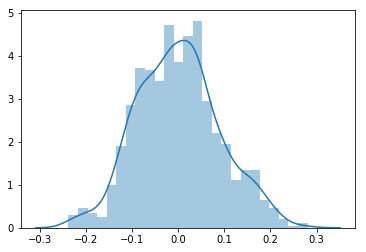

In [89]:
sns.distplot(res.predict()-d.iloc[:,0].values, bins=25)

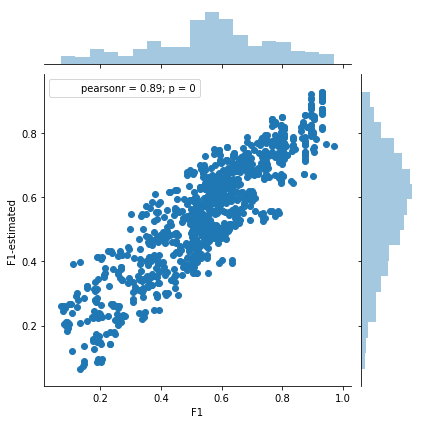

In [90]:
sns.jointplot(x='F1',y='F1-estimated',data=pd.DataFrame({'F1':d.iloc[:,0].values, 'F1-estimated':res.predict()}));